In [22]:
from os import listdir
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [23]:
calibration_files = listdir("./camera_cal/")
# Set aside the last three image to undistort and use the rest for calibration
cal_images = calibration_files[:-3]
cal_eval = calibration_files[-3:]

In [24]:
# Setting object points
nx = 9
ny = 6

objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in the real world
imgpoints = [] # 2D points in the image plane.

# ...using a chessboard image to calibrate the camera

for fname in cal_images:
    img = mpimg.imread("./camera_cal/" + fname)
    # ...and trasforming that image to B/W
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard's corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

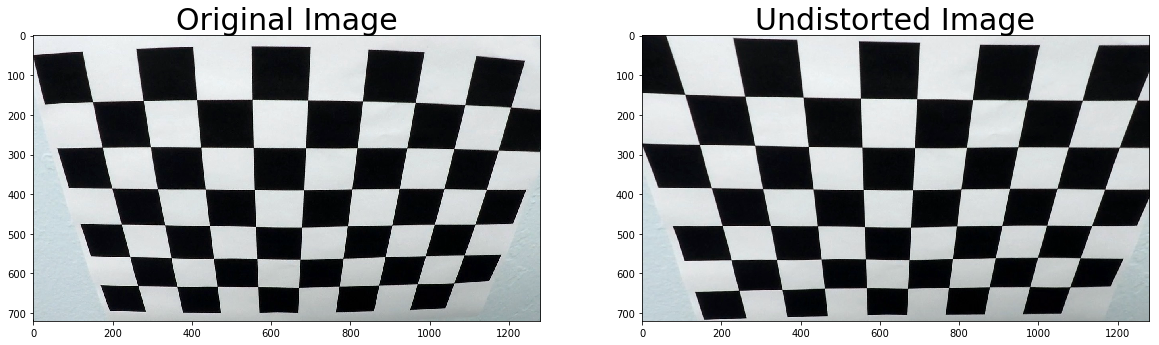

In [25]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/' + cal_eval[2])
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('./output_images/test_undist.jpg',dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [26]:
# Serialize mtx and dist objects
import pickle

with open('mtx.pickle','wb') as f:
    pickle.dump(mtx, f)
    
with open('dist.pickle', 'wb') as f:
    pickle.dump(dist, f)

Now we can apply distorition correction to raw images.

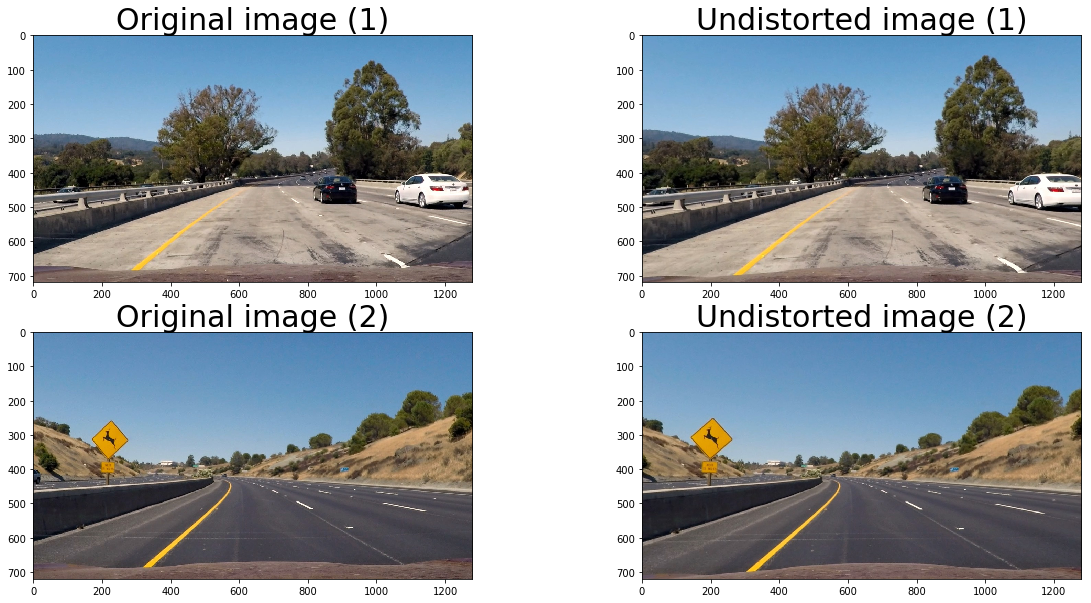

In [27]:
# raw images are located in the test_images folder
path_img_1 = "./test_images/test1.jpg"
path_img_2 = "./test_images/test2.jpg"

img1 = mpimg.imread(path_img_1)
img2 = mpimg.imread(path_img_2)
dst_img1 = cv2.undistort(img1, mtx, dist, None, mtx)
dst_img2 = cv2.undistort(img2, mtx, dist, None, mtx)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes[0, 0].imshow(img1)
axes[0, 0].set_title('Original image (1)', fontsize=30)
axes[0, 1].imshow(dst_img1)
axes[0, 1].set_title('Undistorted image (1)', fontsize=30)
axes[1, 0].imshow(img2)
axes[1, 0].set_title('Original image (2)', fontsize=30)
axes[1, 1].imshow(dst_img2)
axes[1, 1].set_title('Undistorted image (2)', fontsize=30)

Perspective tranform is going to be applied first before applying image thesholding so that we focused on detect the essential element of this project which are the lane lines. Key points on images are going to be transform to have a new perspective of the lane, like in a top-down view.

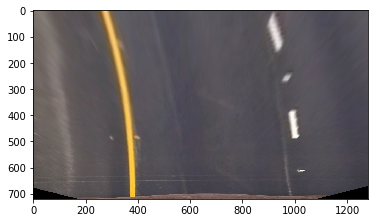

In [28]:
## Define the mapping between pixels of the image taken by the mounted camera of the car and the image in top-down view.
src_points = np.array([(580, 460), (205, 720), (1110, 720), (703, 460)], np.float32)
dst_points = np.array([(320, 0),(320, 720),(960, 720), (960, 0)], np.float32)

# Compute the perspective transform
M = cv2.getPerspectiveTransform(src_points, dst_points)

# Compute the inverse perspective transform
Minv = cv2.getPerspectiveTransform(dst_points, src_points)


dst_shape = (dst_img2.shape[1], dst_img2.shape[0])
# Evaluate the results with the second test image after distortion correction
warped = cv2.warpPerspective(dst_img2, M, dst_shape, flags=cv2.INTER_LINEAR)
plt.imshow(warped)

## Color thresholding

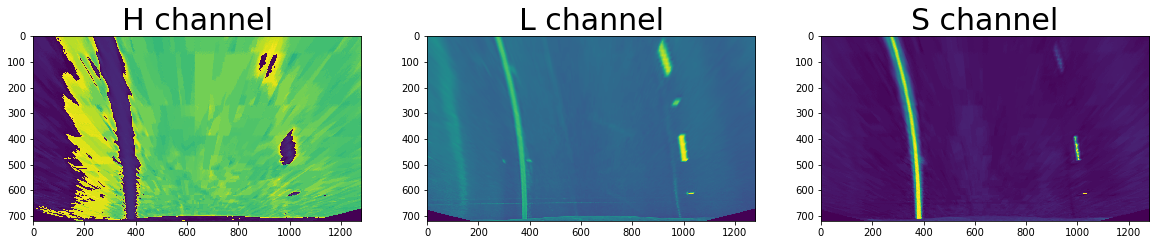

In [29]:
hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(H)
ax1.set_title('H channel', fontsize=30)
ax2.imshow(L)
ax2.set_title('L channel', fontsize=30)
ax3.imshow(S)
ax3.set_title('S channel', fontsize=30)

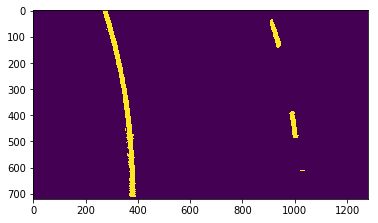

In [30]:
thresh_S=(130,255) # Threshold for the S channel
thresh_L=(200,255) # Threshold for the L channel
binary = np.zeros_like(S)
binary[((L >= thresh_L[0]) & (L <= thresh_L[1])) | ((S >= thresh_S[0]) & (S <= thresh_S[1]))] = 1

plt.imshow(binary)

It seems than combining color thresholding using the L and S channels, lane detection works surprisingly well. The L channel accurately finds the right lane line and the S channel does the same for the left lane line.

## Finding the curvature of the lane

In [31]:
binary_warped = binary
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 12
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

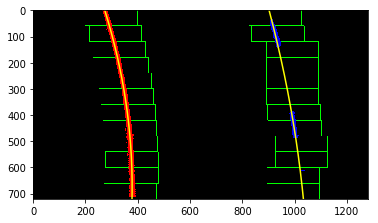

In [32]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [33]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

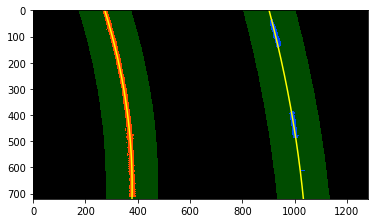

In [34]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

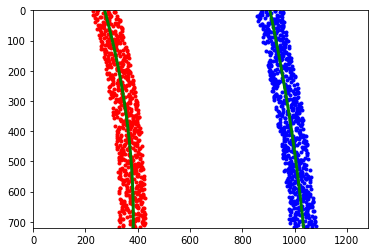

In [35]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
# leftx = np.array([350 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                               for y in ploty])
# rightx = np.array([1030 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                 for y in ploty])

leftx = np.array([l + np.random.randint(-50, high=51) for l in left_fitx])
rightx = np.array([l + np.random.randint(-50, high=51) for l in right_fitx])
#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [36]:
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)

2165.36629436 5641.76483959


In [37]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


711.018425759 m 1818.09015869 m


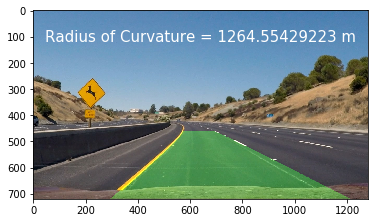

In [38]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img2.shape[1], img2.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(img2, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.text(result.shape[1]/2, 100, 'Radius of Curvature = %s m'%((left_curverad + right_curverad)/2),verticalalignment='center',
horizontalalignment='center',color='white', fontsize=15)